In [1]:
import pint.toa
import pint.models
import pint.fitter
import pint.residuals
import pint.utils
import pint.models.model_builder as mb
import pint.random_models
from pint.phase import Phase
from copy import deepcopy
from collections import OrderedDict
#from astropy import log
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import operator
import time
from pathlib import Path
#import APT_argparse
import socket

In [43]:
f = pint.fitter.WLSFitter(t, m)

f.get_designmatrix()

array([   0.40726644, -215.77663308])

In [85]:
from APT_binary import JUMP_adder_begginning, starting_points
os.chdir("/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary3_1")
#os.chdir("/users/jdtaylor/Jackson/APT/binary3_4")

parfile = Path("fake_1.par")
timfile = Path("fake_1.tim")
m, t = mb.get_model_and_toas(parfile, timfile)
t.table["clusters"] = t.get_clusters()
masks = starting_points(toas = t)[0]
mask = masks[0]
t, m = JUMP_adder_begginning(mask, t, m, "start.tim", "start.par")
t.table['flags']
type(m)

2022-06-24 14:38:49.660 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-24 14:38:49.662 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-24 14:38:49.679 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-24 14:38:49.681 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-24 14:38:49.683 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-24 14:38:49.793 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-24 14:38:49.794 | WARNING  | pint.toa:compute_TDBs:2160 - No ephemeris provided to TOAs object or compute_TDBs. Using DE421
2022-06-24 14:38:49.795 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculation.
2022-06-

pint.models.timing_model.TimingModel

In [3]:
m.as_parfile() # adding jumps natively gives errors so I will add them manually
with open("thisisatest1.par", "w") as parfile:
    parfile.write(m.as_parfile())
    for i in range(1, 31):
        parfile.write(f"JUMP\t\t-jump_tim {i}\t0 1 0\n")
    

In [13]:
from APT_binary import JUMP_adder_begginning, starting_points
os.chdir("/Users/jackson/Desktop/Pint_Personal/APT/binary3_1")

parfile = Path("fake_1.par")
timfile = Path("fake_1.tim")
m, t = mb.get_model_and_toas(parfile, timfile)
t.table["clusters"] = t.get_clusters()
mask, clusters = starting_points(toas = t)
t, m = JUMP_adder_begginning(mask[0], t, m, "thisisatest.tim", "thisisatest.par")

2022-06-23 15:29:14.901 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-23 15:29:14.902 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-23 15:29:14.919 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-23 15:29:14.920 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-23 15:29:14.922 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-23 15:29:15.008 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-23 15:29:15.009 | WARNING  | pint.toa:compute_TDBs:2160 - No ephemeris provided to TOAs object or compute_TDBs. Using DE421
2022-06-23 15:29:15.010 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculation.
2022-06-

In [3]:
m.components

{'AbsPhase': AbsPhase(
     MJDParameter(   TZRMJD              56000.0000000000000000 (d) frozen=True),
     strParameter(   TZRSITE             GBT               frozen=True),
     floatParameter( TZRFRQ              1400.0            (MHz) frozen=True)),
 'Spindown': Spindown(
     floatParameter( F0                  2.4553950186475038 (Hz) +/- 1e-06 Hz frozen=False),
     MJDParameter(   PEPOCH              56000.0000000000000000 (d) frozen=True),
     floatParameter( F1                  0.0               (Hz / s) +/- 0.0 Hz / s frozen=True)),
 'PhaseJump': PhaseJump(
     maskParameter(JUMP1 -jump_tim 1 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP2 -jump_tim 2 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP3 -jump_tim 3 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP4 -jump_tim 4 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP5 -jump_tim 5 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP6 -jump_tim 6 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP7 -jump_tim 7 0.0 +/- 0.0 s (s)),
     maskParameter(JUM

In [36]:
# Now to test out the design matrix

m1 = deepcopy(m)
t1 = deepcopy(t)

f1 = pint.fitter.WLSFitter(t1, m1)
# f = pint.fitter.WLSFitter(t, m)
# f.get_designmatrix()
m1.components

AttributeError: Attribute JUMP not found in TimingModel or any Component

In [60]:
def JUMP_adder_begginning_cluster(
    mask: np.ndarray, toas, model, output_timfile, output_parfile
):
    """
    Adds JUMPs to a timfile as the begginning of analysis.

    mask : a mask to select which toas will not be jumped
    toas : TOA object
    output_timfile : name for the tim file to be written
    output_parfile : name for par file to be written
    """
    t = deepcopy(toas)
    flag_name = "tim_jump"

    former_cluster = t.table[mask]["clusters"][0]
    j = 0
    for i, table in enumerate(t.table[~mask]):
        # if table["clusters"] != former_cluster:
        #     former_cluster = table["clusters"]
        #     j += 1
        table["flags"][flag_name] = str(table["clusters"])
    t.write_TOA_file(output_timfile)

    # model.jump_flags_to_params(t) doesn't currently work (need flag name to be "tim_jump" and even then it still won't work),
    # so the following is a workaround. This is likely related to issue 1294.
    ### (workaround surrounded in ###)
    # with open(output_parfile, "w") as parfile:
    #     parfile.write(model.as_parfile())
    #     for i in set(t.table[~mask]["clusters"]):
    #         parfile.write(f"JUMP\t\t-{flag_name} {i}\t0 1 0\n")
    # model = mb.get_model(output_parfile)
    ###

    return t, model

#os.chdir("/Users/jackson/Desktop/Pint_Personal/APT/binary3_1")
os.chdir(Path("/users/jdtaylor/Jackson/APT/binary_test_data/binary4_100"))

parfile = Path("fake_100.par")
timfile = Path("fake_100.tim")
m, t = mb.get_model_and_toas(parfile, timfile)
t.table["clusters"] = t.get_clusters()
masks, clusters = starting_points(toas = t)
mask = masks[0]
t, m = JUMP_adder_begginning_cluster(mask, t, m, "start.tim", "start.par")

2022-06-24 11:25:43.132 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-24 11:25:43.139 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-24 11:25:43.155 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-24 11:25:43.158 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-24 11:25:43.160 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-24 11:25:43.238 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-24 11:25:43.239 | WARNING  | pint.toa:compute_TDBs:2160 - No ephemeris provided to TOAs object or compute_TDBs. Using DE421
2022-06-24 11:25:43.240 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculation.
2022-06-

In [75]:
# Now to test out the design matrix
f = pint.fitter.WLSFitter(t, m)
m1 = deepcopy(m)
t1 = deepcopy(t)

f1 = pint.fitter.WLSFitter(t1, m1)
# f = pint.fitter.WLSFitter(t, m)
# f.get_designmatrix()

#print(f1.model.as_parfile())
#print(pint.residuals.Residuals(t, f1.model).chi2_reduced)
print(f1.get_designmatrix())
f1.fit_toas()
print("#"*100)
print(f1.get_designmatrix())
#print(pint.residuals.Residuals(t, f1.model).chi2_reduced)
#print(f1.model.as_parfile())


2022-06-23 16:16:31.503 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:97 - Creating and dealing with the single TZR_toa for absolute phase
2022-06-23 16:16:31.507 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-23 16:16:31.508 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-23 16:16:31.510 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-23 16:16:31.511 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-23 16:16:31.512 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-23 16:16:31.515 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-23 16:16:31.515 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculat

(array([[ 4.07266445e-01, -2.15776633e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 4.07266445e-01, -4.17804368e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 4.07266445e-01, -6.19666176e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [ 4.07266445e-01, -2.20250723e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00],
       [ 4.07266445e-01, -2.20252741e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00],
       [ 4.07266445e-01, -2.20254762e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00]]), ['Offset', 'F0', 'JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP22', 'JUMP23', 'JU

2022-06-23 16:16:32.038 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:110 - Done with TZR_toa


####################################################################################################
(array([[ 4.07263201e-01, -2.15774914e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 4.07263201e-01, -4.17801040e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 4.07263201e-01, -6.19661240e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [ 4.07263201e-01, -2.20248968e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00],
       [ 4.07263201e-01, -2.20250987e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00],
       [ 4.07263201e-01, -2.20253007e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00]]), ['Offset', 'F0', 'JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP13', 'J

In [79]:
print(len(f1.get_designmatrix()[0]))
print(len(f1.get_designmatrix()[0][0]))
print(f1.get_designmatrix()[0][0])
print(f.get_designmatrix()[0][0])
print(f.get_designmatrix()[1])

149
32
[   0.4072632 -215.7749143   -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.       ]
[   0.40726644 -215.77663308   -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.        ]
['Offset', 'F0', 'JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP

In [67]:
os.chdir(Path("/users/jdtaylor/Jackson/APT/binary_test_data/binary4_100"))

parfile = "fake_100edit.par"
timfile = "fake_100.timJUMP"
m, t = pint.models.get_model_and_toas(parfile, timfile)

x = t.get_mjds().value
resid = pint.residuals.Residuals(t, m).calc_phase_resids()

# fig, ax = plt.subplots(1,1,figsize=(15,10))
# ax.plot(x, resid, "o")

t.get_clusters() == 5
type(t)

2022-06-24 14:29:31.391 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-24 14:29:31.393 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-24 14:29:31.408 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-24 14:29:31.410 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-24 14:29:31.412 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-24 14:29:31.493 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-24 14:29:31.494 | WARNING  | pint.toa:compute_TDBs:2160 - No ephemeris provided to TOAs object or compute_TDBs. Using DE421
2022-06-24 14:29:31.495 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculation.
2022-06-

pint.toa.TOAs

In [52]:
import pint.models as pm
if socket.gethostname()[0] == "J":
    os.chdir("/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary4_100")
else:
    os.chdir("/users/jdtaylor/Jackson/APT/binary_test_data/binary4_100")
m1, t1 = pm.get_model_and_toas("fake_100sol.par", "fake_100.tim")
# t1.compute_pulse_numbers(m1)
# pn1 = t1.table["pulse_number"]

# m2, t2 = pm.get_model_and_toas("solved_100.par", "fake_100.tim")
# t2.compute_pulse_numbers(m2)
# pn2 = t2.table["pulse_number"]



In [76]:
# t3 = deepcopy(t2)
# dpn = pn2 - pn1
# t3.table["delta_pulse_number"] = dpn
# pn3 = t3.table["pulse_number"]
x = np.array([1,2,3])
y = np.array([1,2])
np.concatenate((x,y))

array([1, 2, 3, 1, 2])

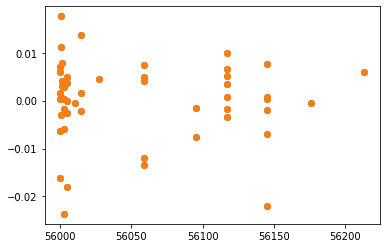

In [58]:
y3 = pint.residuals.Residuals(t3, m1).calc_phase_resids()
y1 = pint.residuals.Residuals(t1, m1).calc_phase_resids()
x1 = t1.get_mjds().value
x3 = t3.get_mjds().value

plt.plot(x3, y3, 'o')
plt.plot(x1, y1, 'o')

In [59]:
t3.table["pulse_number"] - t1.table["pulse_number"] 

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [56]:
"mjd" in t1.table.columns

True

In [8]:
#residuals = np.array([1,2,3,4,2])
residuals = np.array([0.24963299, 0.30871647, 0.37203439, 0.44167943, 0.50239736, -0.43294805])
mjds = np.array([56054.33430246, 56054.34040344, 56054.34650443, 56054.35260039,
       56054.35870137, 56054.36480237])
residualsdif_dif = np.concatenate(
    (np.zeros(1), residuals)
) - np.concatenate((residuals, np.zeros(1)))
mjds_dif = np.concatenate((np.zeros(1), mjds)) - np.concatenate(
    (mjds, np.zeros(1))
)
toa_slopes = (residualsdif_dif / mjds_dif)[1:-1]
print(toa_slopes)
print(toa_slopes > 0)
# want to establish the correct slope direction as that with the longest
# series of adjacent slopes
biggest = 0
location_of_biggest = -1
biggest_is_pos = True
was_pos = True
count = 0
for i, is_pos in enumerate(toa_slopes >= 0):
    if is_pos and was_pos or (not is_pos and not was_pos):
        count += 1
        print(f"{i}: {count}")
        was_pos = is_pos
    elif is_pos or was_pos:
        print("flipped")
        if count > biggest:
            biggest = count
            location_of_biggest = i - 1
            biggest_is_pos = is_pos
        count = 1
        was_pos = is_pos
    # do this check one last time in case the last point is part of the
    # longest series of adjacent slopes
    if count > biggest:
            biggest = count
            location_of_biggest = i # not i - 1 because that last point is like the (i + 1)th element
                                    # flipping slopes
            biggest_is_pos = is_pos

print(f"biggest is {biggest}. location of biggest is {location_of_biggest}")
print(toa_slopes[location_of_biggest-biggest+1:location_of_biggest+1])
print()
print(residuals[:location_of_biggest-biggest+1])
print(residuals[location_of_biggest+2:])




[   9.68426057   10.37830253   11.42478626    9.95216014 -153.31018032]
[ True  True  True  True False]
0: 1
1: 2
2: 3
3: 4
flipped
biggest is 4. location of biggest is 3
[ 9.68426057 10.37830253 11.42478626  9.95216014]

[]
[-0.43294805]


In [2]:
import pint.logging
pint.logging.setup(level = "ERROR")

1

cluster 9
that took 0.002881623000007494 seconds


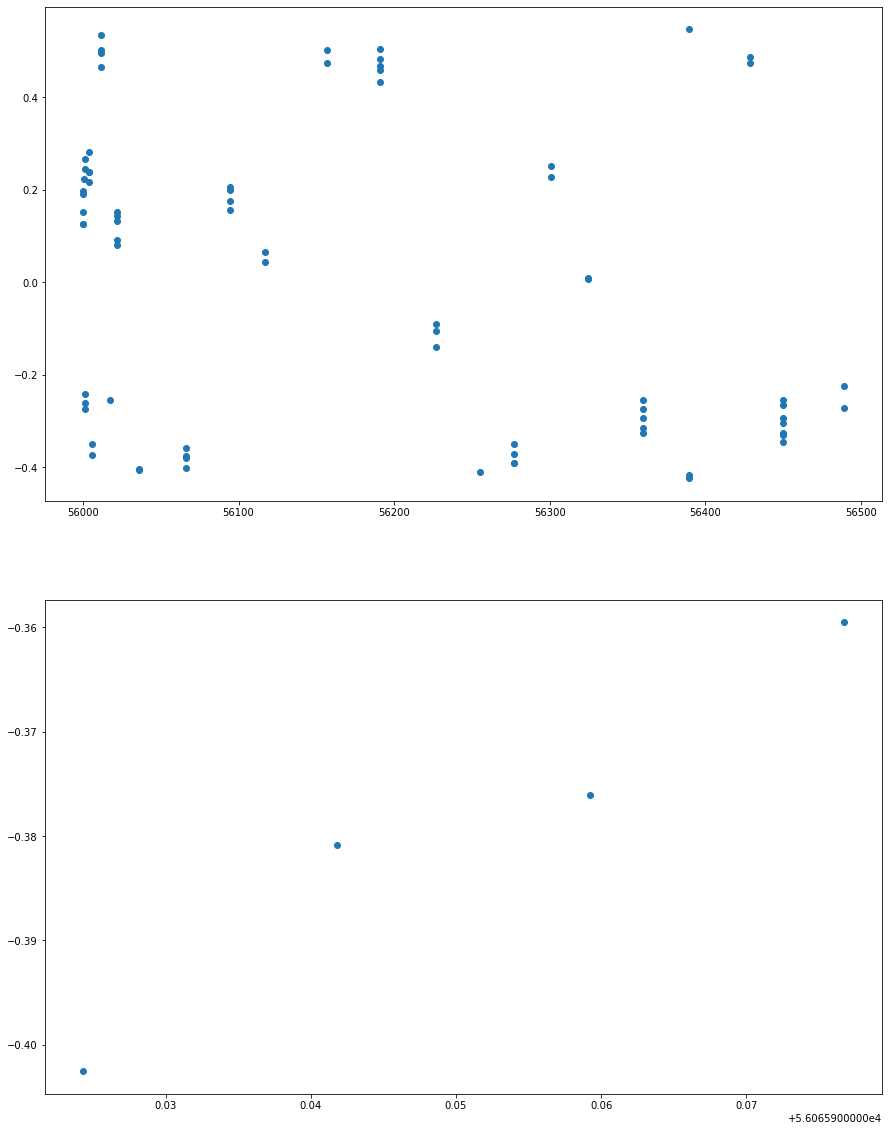

In [2]:
import pint.logging, socket, numpy as np, matplotlib.pyplot as plt, time
from copy import deepcopy
pint.logging.setup(level = "ERROR")

import pint.models as pm
from APT_binary import phase_connector
data_path = "binary6_1"
if socket.gethostname()[0] == "J":
    os.chdir(f"/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/{data_path}")
else:
    os.chdir(f"/users/jdtaylor/Jackson/APT/binary_test_data/{data_path}")
m, t = pm.get_model_and_toas(f"fake_{data_path.split('_')[-1]}.par", f"fake_{data_path.split('_')[-1]}.tim")
if "clusters" not in t.table.columns:
        t.table["clusters"] = t.get_clusters()
if "pulse_number" not in t.table.colnames:
    t.compute_pulse_numbers(m)

y = pint.residuals.Residuals(t, m).calc_phase_resids()
#y1 = pint.residuals.Residuals(t1, m1).calc_phase_resids()
x = t.get_mjds().value

# cluster= 0
# cluster_mask1 = t.table["clusters"] == 0
# cluster_mask2 = t.table["clusters"] == 1
# cluster_mask = np.zeros(len(t.table), dtype=bool)
cluster_mask = t.table["clusters"] == 9
# for i in range(len(cluster_mask1)):
#     if cluster_mask1[i] or cluster_mask2[i]:
#         cluster_mask[i] = True
#t_copy = deepcopy(t)
#t.select(cluster_mask)
t1 = time.monotonic()
phase_connector(t, m, "linear", cluster = 9, wraps = True, mjds_total=x, residuals_total=y)
t2 = time.monotonic()
print(f"that took {t2 - t1} seconds")

# t1 = time.monotonic()
# phase_connector(t, m, "linear", cluster = "all", wraps = True)
# t2 = time.monotonic()
# print(f"that took {t2 - t1} seconds")
# x1 = x[cluster_mask]
# y1 = y[cluster_mask]
#t.table["delta_pulse_number"][-1] = 0
#t_copy.table[cluster_mask] = t.table
x1 = t.get_mjds().value
x1 = x1[cluster_mask]
y1 = pint.residuals.Residuals(t, m).calc_phase_resids()
y1 = y1[cluster_mask]

fig, ax = plt.subplots(2, figsize = (15,20))
ax[0].plot(x, y, 'o')
ax[1].plot(x1, y1, 'o')


# t.compute_pulse_numbers(m)
# t.write_TOA_file("zzz.tim")

In [7]:
mask = np.zeros(len(t_copy), dtype=bool)
mask[0:2] = True
t_copy.table
t=deepcopy(t_copy)
t.select(mask)
t.table["delta_pulse_number"][0:2] = 1
t_copy.table[mask] = t.table


NameError: name 't_copy' is not defined

In [27]:
print(t.table[6]["pulse_number"])
print(t.table[6]["delta_pulse_number"])
print()

t.compute_pulse_numbers(m)
print(t.table[6]["pulse_number"])
print(t.table[6]["delta_pulse_number"])
print()

t.table[6]["delta_pulse_number"] = -2
resid = pint.residuals.Residuals(t, m).calc_phase_resids()
t.compute_pulse_numbers(m)
print(t.table[6]["pulse_number"])
print(t.table[6]["delta_pulse_number"])

82045.0
-1.0

82044.0
-1.0

82043.0
-2.0


In [1]:
y1


NameError: name 'y1' is not defined

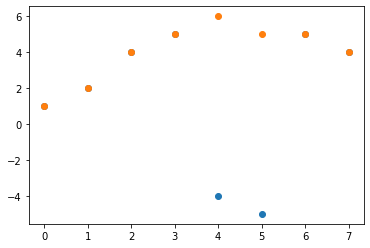

In [5]:
import numpy as np, matplotlib.pyplot as plt
x = np.array([1,2,4,5,-4,-5,5,4])
x1 = np.unwrap(x, period = 10)
plt.plot(np.arange(len(x)), x, "o")
plt.plot(np.arange(len(x1)), x1, "o")

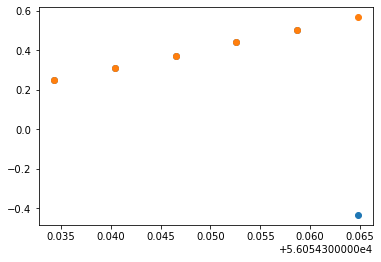

In [10]:
residuals = np.array([0.24963299, 0.30871647, 0.37203439, 0.44167943, 0.50239736, -0.43294805])
mjds = np.array([56054.33430246, 56054.34040344, 56054.34650443, 56054.35260039,
       56054.35870137, 56054.36480237])

residuals_unwrapped = np.unwrap(residuals, period = 1)
plt.plot(mjds, residuals, "o")
plt.plot(mjds, residuals_unwrapped, 'o')

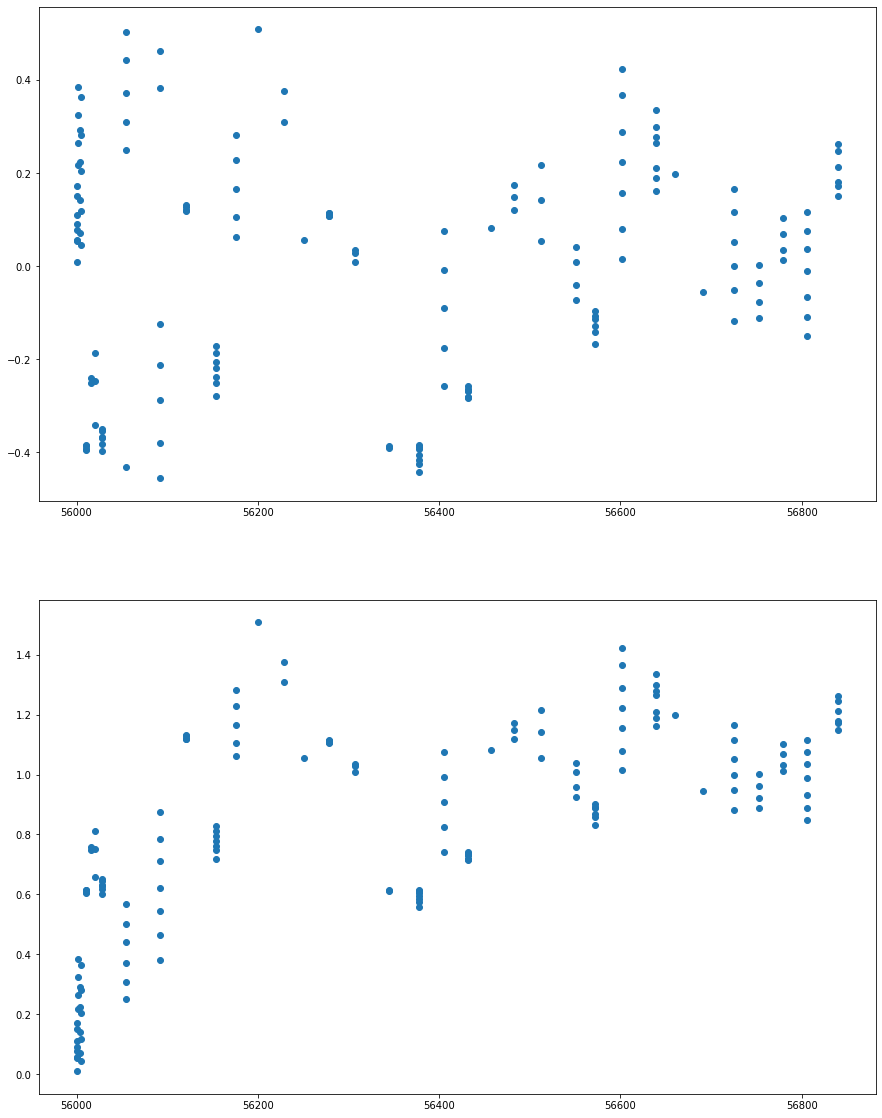

In [16]:
import pint.logging, socket, numpy as np, matplotlib.pyplot as plt, time
from copy import deepcopy
pint.logging.setup(level = "ERROR")

import pint.models as pm
from APT_binary import phase_connector
data_path = "binary4_100"
if socket.gethostname()[0] == "J":
    os.chdir(f"/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/{data_path}")
else:
    os.chdir(f"/users/jdtaylor/Jackson/APT/binary_test_data/{data_path}")
m, t = pm.get_model_and_toas(f"fake_{data_path.split('_')[-1]}.par", f"fake_{data_path.split('_')[-1]}.tim")
if "clusters" not in t.table.columns:
        t.table["clusters"] = t.get_clusters()
if "pulse_number" not in t.table.colnames:
    t.compute_pulse_numbers(m)

y = pint.residuals.Residuals(t, m).calc_phase_resids()
x = t.get_mjds()
y = np.array(y)
fig, ax = plt.subplots(2, figsize = (15,20))
y_unwrapped = np.unwrap(y, period = 1)
ax[0].plot(x, y, 'o')
ax[1].plot(x, y_unwrapped, 'o')

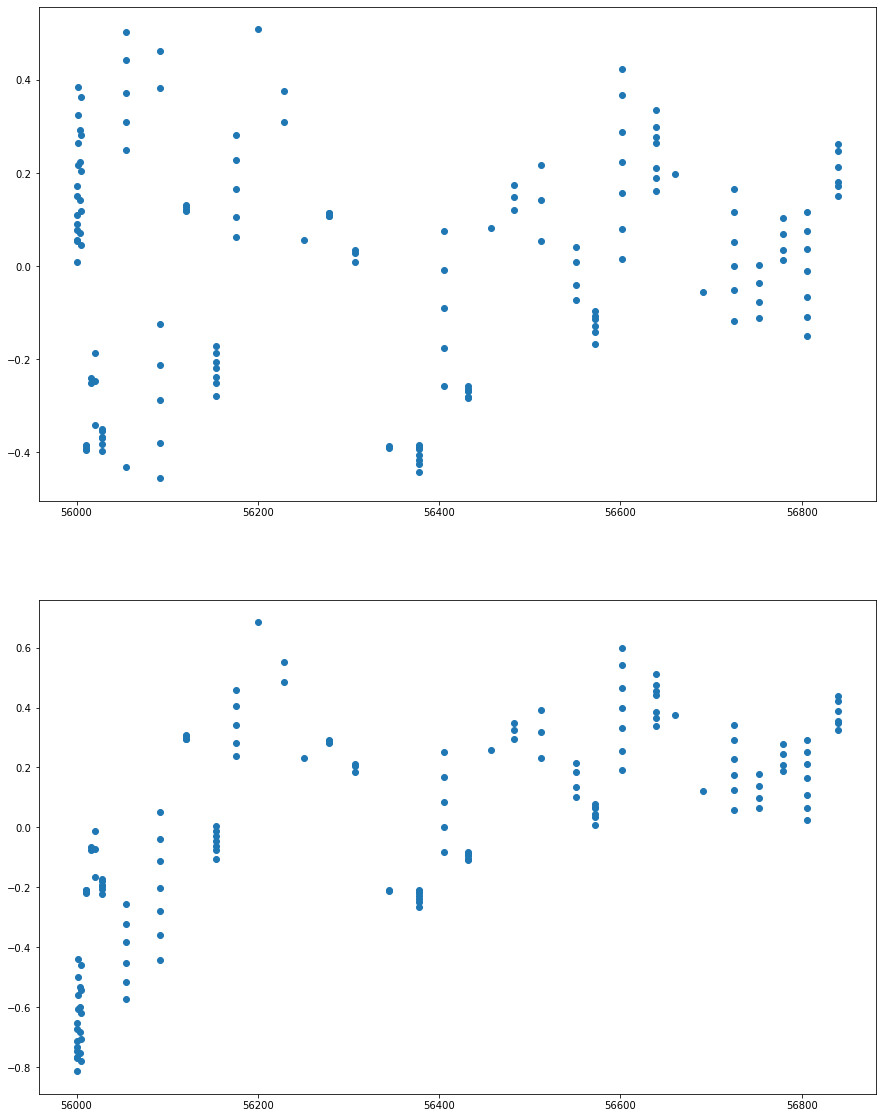

In [20]:
dpn = y_unwrapped - pint.residuals.Residuals(t, m).calc_phase_resids()
t.table["delta_pulse_number"] = dpn
y3 = pint.residuals.Residuals(t, m).calc_phase_resids()

fig, ax = plt.subplots(2, figsize = (15,20))
ax[0].plot(x, y, 'o')
ax[1].plot(x, y3, 'o')


In [9]:
getattr(m, "A1")

floatParameter( A1                  0.030438545804327873 (ls) +/- 0.1 ls frozen=True)

In [36]:
import pint.models.model_builder as mb, matplotlib.pyplot as plt, numpy as np
import pint
from pathlib import Path
pint.logging.setup(level = "ERROR")
os.chdir(Path("/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary6_1"))
m = mb.get_model("fake_1.par")
t = pint.toa.get_TOAs("fake_1.tim")
# getattr(m, "jump_tim 20")
# print(m.as_parfile())
clusters = t.get_clusters()
j = 0
test = [f"JUMP{j:=j+1}" if i != 22+1 else "" for i in range(1, clusters[-1]+2)]
#m.components
test[22]

from APT_binary import phase_connector
t.compute_pulse_numbers(m)
t.table["clusters"] = t.get_clusters()
residuals = pint.residuals.Residuals(t, m).calc_phase_resids()
mjds_total=t.get_mjds().value

fig, ax = plt.subplots(2,1, figsize = (10,15))

ax[0].plot(mjds_total, residuals, 'o')

mask_with_closest = np.logical_or(t.table["clusters"] == 23, t.table["clusters"] == 22)

phase_connector(t, m, "np.unwrap", clusters="all", mjds_total=mjds_total, residuals = residuals, mask_with_closest = mask_with_closest)

residuals = pint.residuals.Residuals(t, m).calc_phase_resids()
ax[1].plot(mjds_total, residuals, 'o')

ValueError: Invalid format specifier

In [82]:
# j = 0
# #print(j:=j+1)
# test = [f"JUMP{(j:=j+1)}" if i != 22 else "" for i in range(clusters[-1]+1)]
# print(test)
# for i,j in enumerate(test):
#     print(i, j)
m = mb.get_model("./alg_saves/fake_1/mask1_cluster0/fake_1_1.par")
getattr(m, "JUMP2").value = 0
getattr(m, "JUMP2").frozen = True
getattr(m, "JUMP2").uncertainty = 0
getattr(m, "JUMP2")

maskParameter(JUMP2 -jump_tim 2 0.0 +/- 0.0 s (s))

In [83]:
for i in range(0):
    print("hi")

In [84]:
m.components

{'AbsPhase': AbsPhase(
     MJDParameter(   TZRMJD              56000.0000000000000000 (d) frozen=True),
     strParameter(   TZRSITE             GBT               frozen=True),
     floatParameter( TZRFRQ              1400.0            (MHz) frozen=True)),
 'Spindown': Spindown(
     floatParameter( F0                  7.3536813633543072466 (Hz) +/- 7.480096906686835e-07 Hz frozen=False),
     MJDParameter(   PEPOCH              56000.0000000000000000 (d) frozen=True),
     floatParameter( F1                  0.0               (Hz / s) +/- 0.0 Hz / s frozen=True)),
 'PhaseJump': PhaseJump(
     maskParameter(JUMP1 -jump_tim 1 0.12759017639708167 +/- 0.012484070555973687 s (s)),
     maskParameter(JUMP2 -jump_tim 2 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP3 -jump_tim 3 0.36552323802824715 +/- 0.02662340729810784 s (s)),
     maskParameter(JUMP4 -jump_tim 4 0.6046937480895088 +/- 0.050719015202058036 s (s)),
     maskParameter(JUMP5 -jump_tim 5 1.4682126918307705 +/- 0.102710967926140